In [1]:
!nvidia-smi

Thu Mar 30 22:40:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:3B:00.0 Off |                  N/A |
|100%   81C    P2   308W / 370W |  20099MiB / 24268MiB |     96%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:86:00.0 Off |                  N/A |
| 75%   

In [2]:
import pickle5 as pickle
import pandas as pd
import tensorflow as tf

tf.device('/device:GPU:2')

/home/gyuseok/anaconda3/envs/hinsage/lib/python3.6/site-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


In [3]:

import pickle5 as pickle

def make_node(dic : dict):
    
    csv_node = []
    wiki_node = []

    for key in dic.keys():
        for value in dic[key]:
            csv_node.append(key)
            wiki_node.append(value)
            
    return csv_node, wiki_node

def load_pickle(name:str):
    with open(f'{name}.pickle','rb') as f:
        return pickle.load(f)

def add_csv_idx(l, num_csv):
    return list(map(lambda x: x + num_csv, l))

wiki_dict = load_pickle("wiki_dict")
csv_dict = load_pickle("csv_dict")
csv2wiki = load_pickle("csv2wiki")
wiki2csv = load_pickle("wiki2csv")
#g = load_pickle("csv_wiki_graph")
embedding = load_pickle("embedding")

num_csv = len(csv2wiki.keys())


related_by_csv, related_by_wiki = make_node(csv2wiki)
related_by_wiki = add_csv_idx(related_by_wiki, num_csv)

related_wiki, related_csv = make_node(wiki2csv)
related_wiki = add_csv_idx(related_wiki, num_csv)


In [4]:

edge_df = pd.DataFrame({
                        "source" : related_by_csv,
                        "target" : related_by_wiki
                        })

edge_df.head()

,source,target
0,0,12
1,0,13
2,0,14
3,0,15
4,0,16


In [5]:
w_edge_df =  edge_df[["source","target"]].value_counts().reset_index()
w_edge_df.columns = ["source","target","weight"]
w_edge_df.head()

,source,target,weight
0,8,13,4
1,1,30,3
2,3,53,3
3,10,102,3
4,7,83,2


In [6]:
from stellargraph import StellarGraph

G = StellarGraph(embedding, 
                 w_edge_df, 
                 is_directed = False)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 118, Edges: 151

 Node types:
  default: [118]
    Features: float32 vector, length 128
    Edge types: default-default->default

 Edge types:
    default-default->default: [151]
        Weights: range=[1, 4], mean=1.11258, std=0.42494
        Features: none


# GraphSAGE

Only we have to consider thing is to check whether there is a link between csv and wiki or not.

https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/graphsage-link-prediction.html

In [7]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, HinSAGE, link_classification

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

In [8]:
edge_splitter_test = EdgeSplitter(G)
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected = True
)

** Sampled 15 positive and 15 negative edges. **


In [9]:
edge_splitter_train = EdgeSplitter(G_test)
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p = 0.1, method="global", keep_connected=True
)

** Sampled 13 positive and 13 negative edges. **


In [10]:
print(G_train.info())


StellarGraph: Undirected multigraph
 Nodes: 118, Edges: 123

 Node types:
  default: [118]
    Features: float32 vector, length 128
    Edge types: default-default->default

 Edge types:
    default-default->default: [123]
        Weights: range=[1, 3], mean=1.07317, std=0.318056
        Features: none


In [11]:
print(G_test.info())

StellarGraph: Undirected multigraph
 Nodes: 118, Edges: 136

 Node types:
  default: [118]
    Features: float32 vector, length 128
    Edge types: default-default->default

 Edge types:
    default-default->default: [136]
        Weights: range=[1, 4], mean=1.10294, std=0.426518
        Features: none


In [12]:
batch_size = 20
epochs = 20
num_samples = [20,10] # the sizes of 1- and 2-hop neighbor samples for GraphSAGE

In [13]:
train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples)
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)


In [14]:
test_gen = GraphSAGELinkGenerator(G_test, batch_size, num_samples)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)


In [15]:
layer_sizes = [20, 20]

graphsage = GraphSAGE(
                        layer_sizes=layer_sizes,
                        generator=train_gen,
                        bias=True,
                        dropout=0.3
)


In [16]:
x_inp, x_out = graphsage.in_out_tensors()
x_inp

[<KerasTensor: shape=(None, 1, 128) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 1, 128) dtype=float32 (created by layer 'input_4')>,
 <KerasTensor: shape=(None, 20, 128) dtype=float32 (created by layer 'input_2')>,
 <KerasTensor: shape=(None, 20, 128) dtype=float32 (created by layer 'input_5')>,
 <KerasTensor: shape=(None, 200, 128) dtype=float32 (created by layer 'input_3')>,
 <KerasTensor: shape=(None, 200, 128) dtype=float32 (created by layer 'input_6')>]

In [17]:
x_out

[<KerasTensor: shape=(None, 20) dtype=float32 (created by layer 'lambda')>,
 <KerasTensor: shape=(None, 20) dtype=float32 (created by layer 'lambda')>]

In [18]:
prediction = link_classification(
    output_dim=1, output_act="relu", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [19]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=["acc"],
)

/home/gyuseok/anaconda3/envs/hinsage/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [20]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

2/2 [==============================] - 0s 35ms/step - loss: 0.6121 - acc: 0.6667

Train Set Metrics of the initial (untrained) model:
	loss: 0.6340
	acc: 0.7308

Test Set Metrics of the initial (untrained) model:
	loss: 0.6121
	acc: 0.6667


In [21]:
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow, verbose=2)


Epoch 1/20
2/2 - 2s - loss: 0.6042 - acc: 0.6923 - val_loss: 0.6406 - val_acc: 0.6333
Epoch 2/20
2/2 - 0s - loss: 0.6384 - acc: 0.6538 - val_loss: 0.6581 - val_acc: 0.6333
Epoch 3/20
2/2 - 0s - loss: 0.5405 - acc: 0.6154 - val_loss: 0.6551 - val_acc: 0.6000
Epoch 4/20
2/2 - 0s - loss: 0.5097 - acc: 0.7308 - val_loss: 0.6649 - val_acc: 0.6333
Epoch 5/20
2/2 - 0s - loss: 0.5809 - acc: 0.7308 - val_loss: 0.6847 - val_acc: 0.6000
Epoch 6/20
2/2 - 0s - loss: 0.4573 - acc: 0.7308 - val_loss: 0.6357 - val_acc: 0.6000
Epoch 7/20
2/2 - 0s - loss: 0.4514 - acc: 0.8462 - val_loss: 0.7037 - val_acc: 0.5333
Epoch 8/20
2/2 - 0s - loss: 0.6810 - acc: 0.5385 - val_loss: 0.6749 - val_acc: 0.6333
Epoch 9/20
2/2 - 0s - loss: 0.5476 - acc: 0.6538 - val_loss: 0.6748 - val_acc: 0.6667
Epoch 10/20
2/2 - 0s - loss: 0.4581 - acc: 0.8462 - val_loss: 0.6953 - val_acc: 0.6333
Epoch 11/20
2/2 - 0s - loss: 0.5223 - acc: 0.7308 - val_loss: 0.7017 - val_acc: 0.6000
Epoch 12/20
2/2 - 0s - loss: 0.5070 - acc: 0.6923 - 

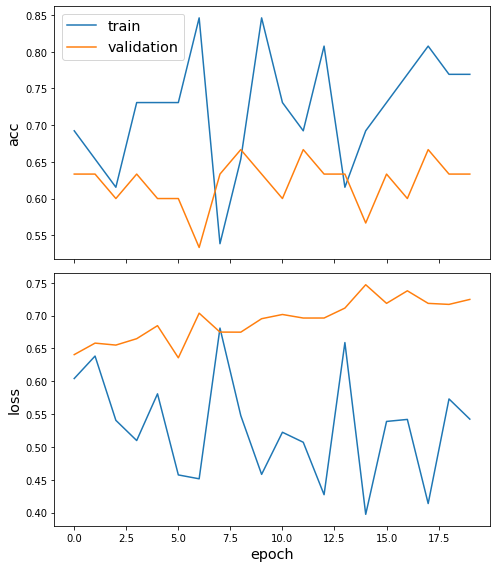

In [22]:
sg.utils.plot_history(history)


In [23]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

2/2 [==============================] - 0s 28ms/step - loss: 0.7141 - acc: 0.6667

Train Set Metrics of the trained model:
	loss: 0.3748
	acc: 0.8462

Test Set Metrics of the trained model:
	loss: 0.7141
	acc: 0.6667


In [24]:
model.predict(test_flow)

array([[0.9747856 ],
       [0.5945711 ],
       [0.30764037],
       [0.96237445],
       [0.7097129 ],
       [0.7520008 ],
       [0.5826384 ],
       [0.3252193 ],
       [0.68893856],
       [0.8883231 ],
       [0.6705205 ],
       [0.19415535],
       [0.54814446],
       [0.8818823 ],
       [0.91222787],
       [0.95188683],
       [0.4362995 ],
       [0.29073653],
       [0.424804  ],
       [0.8106469 ],
       [0.50735795],
       [0.86475325],
       [0.51216805],
       [0.54024357],
       [0.5772613 ],
       [0.21296072],
       [0.        ],
       [0.9007349 ],
       [0.66361254],
       [0.66079736]], dtype=float32)

In [25]:
test_flow.ids

[array([ 7, 83], dtype=uint8),
 array([10, 21], dtype=uint8),
 array([ 5, 56], dtype=uint8),
 array([10, 90], dtype=uint8),
 array([ 6, 51], dtype=uint8),
 array([ 5, 21], dtype=uint8),
 array([ 8, 15], dtype=uint8),
 array([ 3, 49], dtype=uint8),
 array([ 8, 16], dtype=uint8),
 array([ 7, 50], dtype=uint8),
 array([ 2, 21], dtype=uint8),
 array([ 7, 36], dtype=uint8),
 array([ 7, 15], dtype=uint8),
 array([10, 94], dtype=uint8),
 array([ 5, 42], dtype=uint8),
 array([68, 47], dtype=uint8),
 array([65, 20], dtype=uint8),
 array([76, 98], dtype=uint8),
 array([62, 99], dtype=uint8),
 array([22, 86], dtype=uint8),
 array([35, 76], dtype=uint8),
 array([ 55, 106], dtype=uint8),
 array([ 9, 25], dtype=uint8),
 array([ 74, 115], dtype=uint8),
 array([ 4, 41], dtype=uint8),
 array([67, 83], dtype=uint8),
 array([31, 87], dtype=uint8),
 array([ 91, 112], dtype=uint8),
 array([ 6, 91], dtype=uint8),
 array([106,  35], dtype=uint8)]